In [ ]:

pip install --upgrade music21

<ipython-input-57-f0d9a0b77165>:26: RuntimeWarning: divide by zero encountered in divide
  y_values = -(theta[0] * x_values) / theta[1]


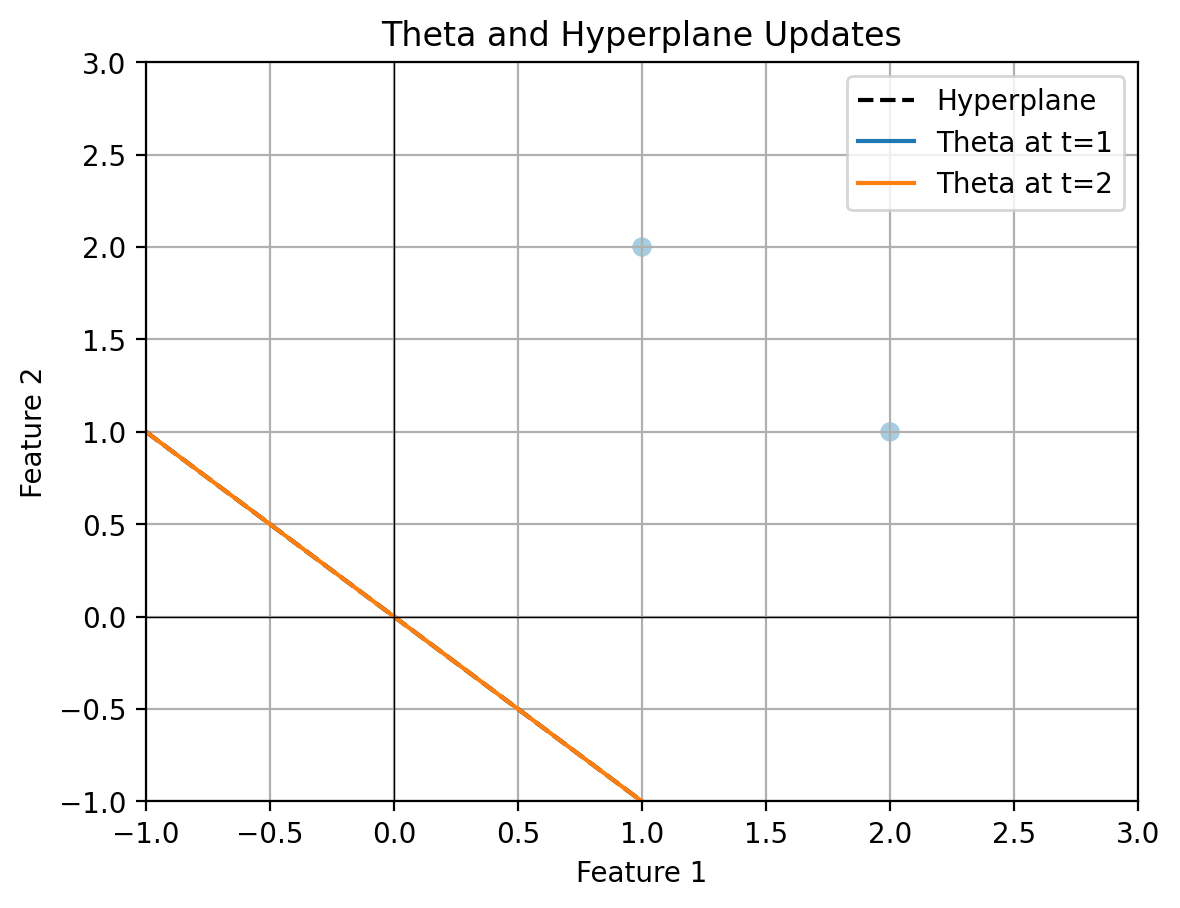

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data points and labels
data_points = np.array([[1, 2], [2, 1]])
labels = np.array([-1, -1])

# Initial theta
theta = np.array([2, 2])

# Plot the data points
plt.scatter(data_points[:, 0], data_points[:, 1], c=labels, cmap=plt.cm.Paired, marker='o')

# Plot the hyperplane defined by theta
x_values = np.linspace(-1, 3, 100)
y_values = -(theta[0] * x_values) / theta[1]  # hyperplane equation: theta0 * x + theta1 * y = 0
plt.plot(x_values, y_values, 'k--', label='Hyperplane')

# Update theta at each step and plot the new hyperplane
for t in range(data_points.shape[0]):
    x = data_points[t]
    y = labels[t]
    hypothesis = np.dot(theta, x)
    if y * hypothesis <= 0:
        theta += y * x
        y_values = -(theta[0] * x_values) / theta[1]
        plt.plot(x_values, y_values, label=f'Theta at t={t+1}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.title('Theta and Hyperplane Updates')
plt.show()

In [ ]:
#DataFlair Automatic Music Generation Project
#load all the libraries
from music21 import *
import glob
import os
from tqdm import tqdm
import numpy as np
import random
from tensorflow.keras.layers import LSTM,Dense,Input,Dropout, GRU,BatchNormalization
from tensorflow.keras.models import Sequential,Model,load_model
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = '/content/drive/MyDrive/Music generation project code/musicgenerationdata/'

In [ ]:
def read_files(file):
  notes=[]
  notes_to_parse=None
  #parse the midi file
  midi=converter.parse(file)
  #seperate all instruments from the file
  instrmt=instrument.partitionByInstrument(midi)

  for part in instrmt.parts:
  #fetch data only of Piano instrument
    if 'Piano' in str(part):
      notes_to_parse=part.recurse()

    #iterate over all the parts of sub stream elements
    #check if element's type is Note or chord
    #if it is chord split them into notes
    for element in notes_to_parse:
      if type(element)==note.Note:
        notes.append(str(element.pitch))
      elif type(element)==chord.Chord:
        notes.append('.'.join(f"{note.Note(n).pitch.pitchClass}{note.Note(n).octave}" for n in element.normalOrder))
      elif isinstance(element, note.Rest):
        notes.append('Rest')

  #return the list of notes
  return notes

#retrieve paths recursively from inside the directories/files
file_path=["schubert","chopin","bach","balakir","beeth","borodin","brahms","burgm","debussy","granados","grieg","haydn","liszt","mendelssohn","mozart","muss","schumann","tschai"]
for file in range(len(file_path)):
  print("files",os.path.join(DATA_DIR,'All Midi Files/'+file_path[file]+'/*.mid'))
  all_files=glob.glob(os.path.join(DATA_DIR,'All Midi Files/'+file_path[file]+'/*.mid'),recursive=True)

#reading each midi file
notes_array = np.array([read_files(i) for i in tqdm(all_files,position=0,leave=True)])

files /content/drive/MyDrive/Music generation project code/musicgenerationdata/All Midi Files/schubert/*.mid
files /content/drive/MyDrive/Music generation project code/musicgenerationdata/All Midi Files/chopin/*.mid
files /content/drive/MyDrive/Music generation project code/musicgenerationdata/All Midi Files/bach/*.mid
files /content/drive/MyDrive/Music generation project code/musicgenerationdata/All Midi Files/balakir/*.mid
files /content/drive/MyDrive/Music generation project code/musicgenerationdata/All Midi Files/beeth/*.mid
files /content/drive/MyDrive/Music generation project code/musicgenerationdata/All Midi Files/borodin/*.mid
files /content/drive/MyDrive/Music generation project code/musicgenerationdata/All Midi Files/brahms/*.mid
files /content/drive/MyDrive/Music generation project code/musicgenerationdata/All Midi Files/burgm/*.mid
files /content/drive/MyDrive/Music generation project code/musicgenerationdata/All Midi Files/debussy/*.mid
files /content/drive/MyDrive/Music g

100%|██████████| 12/12 [00:38<00:00,  3.21s/it]
<ipython-input-74-54ba676b97c9>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  notes_array = np.array([read_files(i) for i in tqdm(all_files,position=0,leave=True)])


In [ ]:
#unique notes
notess = sum(notes_array,[])
unique_notes = list(set(notess))
print("Unique Notes:",len(unique_notes))

#notes with their frequency
freq=dict(map(lambda x: (x,notess.count(x)),unique_notes))

#get the threshold frequency
for i in range(30,100,20):
  print(i,":",len(list(filter(lambda x:x[1]>=i,freq.items()))))

Unique Notes: 244
30 : 96
50 : 65
70 : 56
90 : 51


In [ ]:
#filter notes greater than threshold i.e. 50
freq_notes=dict(filter(lambda x:x[1]>=50,freq.items()))

#create new notes using the frequent notes
new_notes=[[i for i in j if i in freq_notes] for j in notes_array]

In [ ]:
#dictionary having key as note index and value as note
ind2note=dict(enumerate(freq_notes))

#dictionary having key as note and value as note index
note2ind=dict(map(reversed,ind2note.items()))

In [ ]:
#timestep
timesteps=50

#store values of input and output
x=[] ; y=[]

for i in new_notes:
 for j in range(0,len(i)-timesteps):
  #input will be the current index + timestep
  #output will be the next index after timestep
  inp=i[j:j+timesteps] ; out=i[j+timesteps]

  #append the index value of respective notes
  x.append(list(map(lambda x:note2ind[x],inp)))
  y.append(note2ind[out])

x_new=np.array(x)
y_new=np.array(y)

In [ ]:
#reshape input and output for the model
x_new = np.reshape(x_new,(len(x_new),timesteps,1))
y_new = np.reshape(y_new,(-1,1))

#split the input and value into training and testing sets
#80% for training and 20% for testing sets
x_train,x_test,y_train,y_test = train_test_split(x_new,y_new,test_size=0.3,random_state=36)

In [ ]:

#create the model
model = Sequential()
# Create two stacked GRU layers with the latent dimension of 256
model.add(LSTM(256, return_sequences=True, input_shape=(x_new.shape[1], x_new.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(GRU(256, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))

#fully connected layer for the output with softmax activation
model.add(Dense(len(note2ind),activation='softmax'))
model.summary()



In [ ]:
from keras.optimizers import Adamax

# compile the model using Adam optimizer
optimizer = Adamax(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
print(x_train.shape,y_train.shape,"shapes",x_test.shape,y_test.shape)
#train the model on training sets and validate on testing sets
model.fit(
 x_train,y_train,
 batch_size=128,epochs=80,
 validation_data=(x_test,y_test))

(9723, 50, 1) (9723, 1) shapes (4168, 50, 1) (4168, 1)
Epoch 1/80
76/76 [==============================] - 13s 77ms/step - loss: 3.7766 - accuracy: 0.3011 - val_loss: 3.7359 - val_accuracy: 0.3201
Epoch 2/80
76/76 [==============================] - 4s 55ms/step - loss: 3.5451 - accuracy: 0.3233 - val_loss: 3.6761 - val_accuracy: 0.3201
Epoch 3/80
76/76 [==============================] - 4s 56ms/step - loss: 3.4526 - accuracy: 0.3291 - val_loss: 3.6713 - val_accuracy: 0.3174
Epoch 4/80
76/76 [==============================] - 4s 57ms/step - loss: 3.3784 - accuracy: 0.3278 - val_loss: 3.5125 - val_accuracy: 0.3174
Epoch 5/80
76/76 [==============================] - 4s 57ms/step - loss: 3.2878 - accuracy: 0.3317 - val_loss: 3.4512 - val_accuracy: 0.3225
Epoch 6/80
76/76 [==============================] - 4s 57ms/step - loss: 3.2239 - accuracy: 0.3355 - val_loss: 3.3798 - val_accuracy: 0.3301
Epoch 7/80
76/76 [==============================] - 4s 57ms/step - loss: 3.1499 - accuracy: 0.3363

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc} Test Loss: {test_loss}")


In [ ]:
train_loss, train_acc = model.evaluate(x_train, y_train)
print(f"Train Accuracy: {train_acc} Train loss: {train_loss}")

In [ ]:
#save the model for predictions
model.save("s2s1")

In [ ]:
# #load the model
# model = load_model("s2s1")
# #generate random index
# index = np.random.randint(0,len(x_test)-1)
# #get the data of generated index from x_test
# music_pattern = x_test[index]
# out_pred=[] #it will store predicted notes

# #iterate till 200 note is generated
# for i in range(200):

#  #reshape the music pattern
#  music_pattern = music_pattern.reshape(1,len(music_pattern),1)
#  # Get the predicted output probabilities from the model
#  pred_probs = model.predict(music_pattern)[0]
#  # Select the top 7 probabilities and standardize them
#  top_indices = np.argsort(pred_probs)[-7:]
#  top_probs = pred_probs[top_indices]
#  standardized_probs = top_probs / np.sum(top_probs)
#  # Sample the next note index from the modified probability distribution
#  pred_index = np.random.choice(top_indices, p=standardized_probs)


# #  #get the maximum probability value from the predicted output
# #  pred_index = np.argmax(model.predict(music_pattern))
#  #get the note using predicted index and
#  #append to the output prediction list
#  out_pred.append(ind2note[pred_index])
#  music_pattern = np.append(music_pattern,pred_index)

#  #update the music pattern with one timestep ahead
#  music_pattern = music_pattern[1:]

# Assuming you have imported necessary libraries and loaded the model
from keras.models import load_model

# Load the model
model = load_model("s2s1")

# Generate random index
index = np.random.randint(0, len(x_test)-1)

# Get the data of the generated index from x_test
music_pattern = x_test[index]
out_pred = []  # It will store predicted notes

# Iterate till 200 notes are generated
for i in range(200):
    # Reshape the music pattern
    music_pattern = music_pattern.reshape(1, len(music_pattern), 1)

    # Get the predicted output probabilities from the model
    pred_probs = model.predict(music_pattern)[0]

    # Select the top 7 probabilities and standardize them
    top_indices = np.argsort(pred_probs)[-7:]
    top_probs = pred_probs[top_indices]
    standardized_probs = top_probs / np.sum(top_probs)

    # Sample the next note index from the modified probability distribution
    pred_index = np.random.choice(top_indices, p=standardized_probs)

    # Get the note using predicted index and append to the output prediction list
    out_pred.append(ind2note[pred_index])

    # Update the music pattern with one timestep ahead
    music_pattern = np.append(music_pattern, pred_index)
    music_pattern = music_pattern[1:]

In [ ]:
# output_notes = []
# for offset,pattern in enumerate(out_pred):
#   #if pattern is a chord instance
#   if ('.' in pattern) or pattern.isdigit():
#     if pattern == 'Rest':
#       new_note = note.Rest()
#     else:
#       #split notes from the chord
#       notes_in_chord = pattern.split('.')
#       notes = []
#       for current_note in notes_in_chord:
#         i_curr_note=int(current_note)
#         #cast the current note to Note object and
#         #append the current note
#         new_note = note.Note(i_curr_note)
#         new_note.storedInstrument = instrument.Piano()
#         notes.append(new_note)

#       #cast the current note to Chord object
#       #offset will be 1 step ahead from the previous note
#       #as it will prevent notes to stack up
#       new_chord = chord.Chord(notes)
#       new_chord.offset = offset
#       output_notes.append(new_chord)

#   else:
#     #cast the pattern to Note object apply the offset and
#     #append the note
#     new_note = note.Note(pattern)
#     new_note.offset = offset
#     new_note.storedInstrument = instrument.Piano()
#     output_notes.append(new_note)

# #save the midi file
# midi_stream = stream.Stream(output_notes)
# midi_stream.write('midi', fp='pred_music4.mid')

output_notes = []

for offset, pattern in enumerate(out_pred):
    if pattern == 'Rest':
        new_note = note.Rest()
    elif '.' in pattern or pattern.isdigit():
        if pattern.isdigit():
            notes_in_chord = [pattern]
        else:
            notes_in_chord = pattern.split('.')

        notes = []
        for current_note in notes_in_chord:
            i_curr_note = int(current_note)
            new_note = note.Note(i_curr_note)
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)

        if len(notes) > 1:
            new_chord = chord.Chord(notes)
            new_note = new_chord
    else:
        new_note = note.Note(pattern)
        new_note.storedInstrument = instrument.Piano()

    new_note.offset = offset
    output_notes.append(new_note)

# Save the MIDI file
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='pred_music4.mid')
